In [1]:
import numpy as np
import math
import matplotlib.pylab as plt
import librosa
import librosa.display
import pandas as pd
import midi
import glob

%matplotlib inline

In [2]:
def parse_midi(fname, instrument_id):
    pattern = midi.read_midifile(fname)    
    bpm = list(filter(lambda x: isinstance(x, midi.SetTempoEvent), pattern[0]))[0].bpm
    tdict = {
        midi.NoteOnEvent: 1,
        midi.NoteOffEvent: -1
    }
    events = []
    for i in range(1, 5):    
        t = np.cumsum([e.tick for e in pattern[i]], dtype=np.int32)                         
        events.extend([(t, i - 1, tdict[e.__class__], e.pitch) for (t, e) in zip(t, pattern[i]) if e.__class__ in tdict])
    events = list(sorted(events, key=lambda x: (x[0], x[2])))
    
    chord = [0] * 4
    
    chords = []    
        
    for i in range(len(events)):
        if (i > 0) and (events[i - 1][0] != events[i][0]):
            chords.append((events[i - 1][0], tuple(chord)))            
        if events[i][2] == 1:
            chord[events[i][1]] = events[i][3]            
        else:            
            chord[events[i][1]] = 0            
    chords.append((events[-1][0], tuple(chord)))
    
    score = []
    for (t, chord) in chords:
        if len(score) > 0 and score[-1][-1] == chord[instrument_id]:
            continue            
        score.append((t, t / pattern.resolution, t * 60000.0 / bpm / pattern.resolution, chord[instrument_id]))
        
                        
            
    return pd.DataFrame(score)

def wav_features(fname):
    sr = 44100
    r, _ = librosa.load(fname, sr=sr, offset=0.023)
    n_fft, hop_length = 1024, 441
    features = np.vstack([
        librosa.feature.rmse(r, frame_length=n_fft, hop_length=hop_length),
        librosa.feature.spectral_centroid(r, sr=sr, n_fft=n_fft, hop_length=hop_length),
        librosa.feature.spectral_bandwidth(r, sr=sr, n_fft=n_fft, hop_length=hop_length),
        librosa.feature.mfcc(r, sr=sr, n_mfcc=5, n_fft=n_fft, hop_length=hop_length)        
    ]).T
    return features

In [3]:
instruments = {
    'violin': 0,
    'clarinet': 1,
    'saxphone': 2,
    'bassoon': 3,
}

instrument = 'clarinet'

dirs = list(sorted(glob.glob('./data/Bach10/??-*')))
mid_files = list(map(lambda x: '%s/%s.mid' % (x, x.split('/')[-1]), dirs))
wav_files = list(map(lambda x: '%s/%s-%s.wav' % (x, x.split('/')[-1], instrument), dirs))
asl_files = list(map(lambda x: '%s/%s.asl' % (x, x.split('/')[-1]), dirs))

alignments = []
features = []
scores = []
for i in range(10):        
    alignments.append(pd.read_csv(asl_files[i], sep='\t', header=None, index_col=None))     
    scores.append(parse_midi(mid_files[i], instruments[instrument]))
    features.append(wav_features(wav_files[i]))
    features[-1] = features[-1][:alignments[-1].shape[0]]
    ids = alignments[-1][2] > 0.0
    alignments[-1] = alignments[-1][ids]
    alignments[-1][2] -= alignments[-1][2].min() - np.modf(alignments[-1][2].min())[0]
    features[-1] = features[-1][ids]
    alignments[-1] = alignments[-1].iloc[::4]
    features[-1] = features[-1][::4]
    
    scores[-1][1] -= scores[-1][1][0]    

In [4]:
def grountruth_matrix(alignment, s):
    b = alignment[2].copy()
    mx = np.ceil(np.max(alignment[2]) * 2) / 2    
    #s = np.arange(0.0, mx, 0.5)        
    #print(s, np.arange(0.0, mx, 0.5))
    #Y = ((b[:, None] >= s[None, :]) & (b[:, None] < s[None, :] + 0.5)).astype(np.int32)
    Y = ((b[:, None] >= s[None, :-1]) & (b[:, None] < s[None, 1:])).astype(np.int32)
    return Y

def prepare(scores, alignments):
    S = set(sum(map(lambda x: x[3].tolist(), scores), []))
    K = len(S)    
    id_to_key = {i: k for i, k in enumerate(S)}
    key_to_id = {k: i for i, k in enumerate(S)}
    
    GTs = []
    Bs = []
    
    SYs = []
    
    for k in range(len(scores)):        
        GT = grountruth_matrix(alignments[k], scores[k][1])
        B = np.array([key_to_id[v] for v in scores[k][3][:-1]], dtype=np.int32)
        #j = 0
        #for i in range(B.shape[0]):
        #    while (2 * scores[k][1][j + 1] <= i):
        #        j += 1            
        #    B[i] = key_to_id[scores[k][3][j]]
        GTs.append(GT)
        Bs.append(B)
        
        SY = np.zeros(alignments[k].shape[0], dtype=np.int32)
        j = 0
        for i in range(alignments[k].shape[0]):
            while (scores[k][1][j + 1] <= alignments[k].iloc[i, 2]):
                j += 1            
            SY[i] = key_to_id[scores[k][3][j]]
        SYs.append(SY)
        
    return GTs, Bs, SYs, K
    

In [5]:
GTs, Bs, SYs, K = prepare(scores, alignments)

In [6]:
K

18

In [7]:
np.max(alignments[0][2]), np.max(scores[0][1][:-1])

(31.948999999999998, 31.0)

In [8]:
GTs[0].shape

(601, 26)

In [9]:
import sklearn
X_train = np.vstack(features[1:])
Y_train = np.concatenate(SYs[1:])


X_test = features[0].copy()
Y_test = SYs[0].copy()

m, s = np.mean(X_train, axis=0, keepdims=True), np.std(X_train, axis=0, keepdims=True)
X_train = (X_train - m) / s
X_test = (X_test - m) / s

clf = sklearn.linear_model.LogisticRegression(C=1e4, solver='lbfgs', multi_class='multinomial', verbose=True, max_iter=1000)
clf.fit(X_train, Y_train)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.2s finished


LogisticRegression(C=10000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=None, solver='lbfgs', tol=0.0001, verbose=True,
          warm_start=False)

In [10]:
print(np.mean(clf.predict_log_proba(X_train)[np.arange(X_train.shape[0]), Y_train]))
print(np.mean(clf.predict(X_train) == Y_train))
print('---')
print(np.mean(clf.predict_log_proba(X_test)[np.arange(X_test.shape[0]), Y_test]))
print(np.mean(clf.predict(X_test) == Y_test))


-1.37168895046
0.637728194726
---
-1.18061476266
0.668885191348


In [11]:
clf.predict_log_proba(X_test).min()

-60.260876888063336

In [12]:
theta = -clf.predict_log_proba(X_test)[np.arange(X_test.shape[0])[:, None], Bs[-1][None, :]]
theta.shape

(601, 49)

In [13]:
def DTW(theta):
    D = np.zeros((theta.shape[0] + 1, theta.shape[1] + 1))
    D[0, 1:] = 1e20
    D[1:, 0] = 1e20 
    Q = np.zeros((theta.shape[0] + 1, theta.shape[1] + 1, 2), dtype=np.int32)    
    for i in range(1, theta.shape[0] + 1):
        tmp = np.hstack([D[i - 1, 1:][:, None], D[i - 1, :-1][:, None]]) + theta[i - 1, :][:, None]
        Q[i - 1, np.arange(theta.shape[1]), np.argmin(tmp, axis=1)] = 1                 
        D[i, 1:] = np.sum(tmp * Q[i - 1, :-1], axis=1)        
        
    Y = np.zeros((theta.shape[0] + 1, theta.shape[1] + 1), dtype=np.int32)
    Y[-1, -1] = 1
    Q[-1, -1] = [0, 1]
    j = theta.shape[1] - 1    
    for i in range(theta.shape[0] - 1, -1, -1):
        Y[i, :-1] = np.sum(
            np.hstack([Y[i + 1, :-1][:, None], Y[i + 1, 1:][:, None]]) * 
            np.hstack([Q[i + 1, :-1, 0][:, None], Q[i + 1, 1:, 1][:, None]]), axis=1)
    
    return D[:-1, :-1], Y[:-1, :-1]

def MAD(Y, GT):
    return np.sum(np.cumsum(Y - GT, axis=1) ** 2) / GT.shape[0]

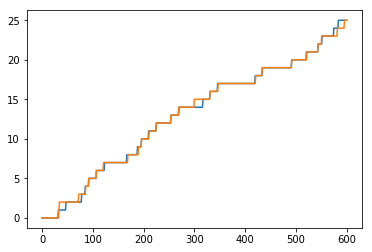

0.114808652246


In [14]:
#theta = np.random.randn(*GTs[-1].shape)
theta = -clf.predict_log_proba(X_test)[np.arange(X_test.shape[0])[:, None], Bs[0][None, :]]
v, Y = DTW(theta)
#Y = np.zeros_like(GTs[0])
#k = (Y.shape[0] + Y.shape[1] - 1) // Y.shape[1]
#for i in range(Y.shape[1]):
#    Y[i * k:(i + 1) * k, i] = 1

plt.plot(np.where(GTs[0])[1])
plt.plot(np.where(Y)[1])
plt.show()
print(MAD(Y, GTs[0]))

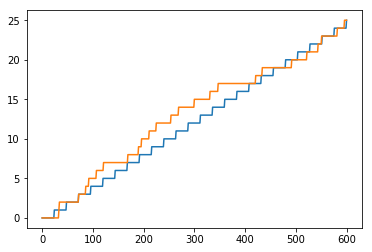

In [15]:
Y_test = np.zeros_like(Y)
k = (Y_test.shape[0] + Y_test.shape[1] - 1) // Y_test.shape[1]
for i in range(Y_test.shape[1]):
    Y_test[i * k:(i + 1) * k, i] = 1
plt.plot(np.where(Y_test)[1])
plt.plot(np.where(Y)[1])
plt.show()

In [16]:
np.sum((Y.astype(np.float32) - Y_test.astype(np.float32)).cumsum(axis=1) ** 2, axis=0)

array([  9.,  14.,   0.,  10.,  28.,  37.,  47.,  23.,  26.,  44.,  53.,
        63.,  58.,  67.,  60.,  53.,  61.,  11.,  22.,  12.,  18.,  16.,
         1.,   6.,   4.,   0.], dtype=float32)